In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import pandas as pd
import tensorflow as tf
from audio_globals import n_mels,slice_lenght,overlap
from sklearn.model_selection import train_test_split
import os
import keras.backend as K
import shutil
from librosa.feature import melspectrogram


In [17]:
filtered_df= pd.read_csv("esc-50-data.csv")

In [13]:
filtered_df['label'].nunique()
label_one_hot_class = {}
for index, row in filtered_df.iterrows():
    label_one_hot_class[row['label']]= row['category']
num_classes = filtered_df['label'].nunique()

In [14]:
num_classes

50

In [33]:
def remove_silence(y, top_db=20):

    # Detect the non-silent parts
    non_silent_parts = librosa.effects.split(y, top_db=top_db)

    # Extract the non-silent segments and concatenate them
    non_silent_audio = np.concatenate([y[start:end] for start, end in non_silent_parts])

    return non_silent_audio, sr
def peak_normalize(audio, target_peak=1):
    max_amplitude = np.max(np.abs(audio))
    scaling_factor = target_peak / max_amplitude
    normalized_audio = audio * scaling_factor
    return normalized_audio
def apply_compression(wav_slice, sr):
    # Example of dynamic range compression
    # Adjust parameters as needed for your use case
    return librosa.effects.percussive(wav_slice)

def apply_equalization(wav_slice, sr):
    # Example of equalization (EQ) changes
    # This is a placeholder; actual EQ changes require more complex processing
    return librosa.effects.harmonic(wav_slice)

def apply_reverb(wav_slice, sr):
    # Example of adding reverberation
    # This is a placeholder; actual reverberation requires convolution with an impulse response
    return wav_slice * np.random.uniform(0.8, 1.2)

def preprocess_and_save(file_path, label, sr, mels, slice_length, overlap, save_dir, is_test=False):
    wav, _ = librosa.load(file_path, sr=sr)
    wav = peak_normalize(wav)
    wav,_ = remove_silence(wav)
    overlap = slice_length*(overlap/100)
    step_size = slice_length - overlap
    num_slices = int(max(1, 1 + (len(wav) - slice_length) // step_size))
    
    augmentations = ['pitch_shift', 'time_stretch', 'noise_addition','original']
    # Process each slice and augmentation
    for slice_num in range(num_slices):
        if is_test:
            start = int(slice_num * step_size)
            end = int(start + slice_length)
            wav_slice = wav[start:end]
            if len(wav_slice) < slice_length:
                wav_slice = np.pad(wav_slice, (0, slice_length - len(wav_slice)), mode='constant')
            S = librosa.feature.melspectrogram(y=wav_slice, sr=int(sr), n_mels=mels, n_fft=1024, hop_length=512)
            S_dB = librosa.util.normalize(librosa.power_to_db(S, ref=np.max))

            # Save each normalized spectrogram slice
            file_name = f'{label}_{os.path.basename(file_path).split(".")[0]}_{slice_num}.npy'
            np.save(os.path.join(save_dir, file_name), S_dB)
        else:
            for aug in augmentations:
                start = int(slice_num * step_size)
                end = int(start + slice_length)
                wav_slice = wav[start:end]
                # Pad if the slice is shorter than the expected length
                if len(wav_slice) < slice_length:
                    shortfall = slice_length - len(wav_slice)
                    repeated_portion = wav_slice[:shortfall]  
                    wav_slice = np.concatenate([wav_slice, repeated_portion])
                    wav_slice = np.pad(wav_slice, (0, slice_length - len(wav_slice)), mode='constant')
                # Apply augmentation
                if aug == 'pitch_shift':
                    pitch_shift = np.random.randint(-2, 3)  # Pitch shift range
                    wav_slice = librosa.effects.pitch_shift(wav_slice, sr=sr, n_steps=pitch_shift)
                elif aug == 'time_stretch':
                    stretch_rate = np.random.uniform(0.8, 1.2)  # Time stretch range
                    wav_slice = librosa.effects.time_stretch(wav_slice, rate=stretch_rate)
                    wav_slice = wav_slice[:slice_length]
                    if len(wav_slice) < slice_length:
                        shortfall = slice_length - len(wav_slice)
                        wav_slice = np.pad(wav_slice, (0, shortfall), mode='constant')
                elif aug == 'noise_addition':
                    noise_level = np.random.uniform(0.001, 0.01)  # Noise level
                    wav_slice = wav_slice + noise_level * np.random.randn(len(wav_slice))
                # Create a Mel-scaled power (energy-squared) spectrogram
                S = librosa.feature.melspectrogram(y=wav_slice, sr=int(sr), n_mels=mels, n_fft=1024, hop_length=512)
                S_dB = librosa.util.normalize(librosa.power_to_db(S, ref=np.max))

                # Save each normalized spectrogram slice
                file_name = f'{label}_{os.path.basename(file_path).split(".")[0]}_{slice_num}_{aug}.npy'
                np.save(os.path.join(save_dir, file_name), S_dB)
        
def process_and_save(df, sr, mels, slice_length, overlap, save_dir, is_test=False):
    for _, row in df.iterrows():
        preprocess_and_save(row['path'], row['label'], sr, mels, slice_length, overlap, save_dir,is_test)

In [34]:
train_df, test_df = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df['label'])
wav, sr = librosa.load(train_df.iloc[0]['path'])

In [35]:
save_dir_train = os.path.join("data", "train")
save_dir_val = os.path.join("data", "val")
save_dir_test = os.path.join("data", "test")

In [36]:
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Usage
save_dir_train = os.path.join("data", "train")
save_dir_val = os.path.join("data", "val")
save_dir_test = os.path.join("data", "test")

def clear_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(directory)

clear_directory(save_dir_train)
clear_directory(save_dir_val)
clear_directory(save_dir_test)
process_and_save(train_df, sr, n_mels, slice_lenght,0, save_dir_train)
print("processed train")
process_and_save(val_df, sr, n_mels, slice_lenght,0, save_dir_val,is_test=True)
print("processed val")
process_and_save(test_df, sr, n_mels, slice_lenght,0, save_dir_test, is_test=True)
print("processed test")


processed train
processed val
processed test


In [37]:
def map_labels(label, label_mapping):
    return label_mapping[label]

In [38]:
def load_spectrogram(file_path, num_classes,label_mapping):
    spectrogram = np.load(file_path)
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    original_label = int(os.path.basename(file_path).split('_')[0])
    mapped_label = map_labels(original_label, label_mapping)
    if np.isinf(spectrogram).any() or np.isnan(spectrogram).any():
        raise ValueError("Spectrogram contains inf or NaN values after normalization")

    label_one_hot = tf.keras.utils.to_categorical(mapped_label, num_classes=num_classes)
    return spectrogram, label_one_hot

def spectrogram_generator(file_paths,num_classes,label_mapping):
    for file_path in file_paths:
        spectrogram, label = load_spectrogram(file_path,num_classes,label_mapping)
        yield spectrogram, label

def get_spectrogram_shape(sample_file_path,num_classes,label_mapping):
    sample_spectrogram, _ = load_spectrogram(sample_file_path,num_classes,label_mapping)
    return sample_spectrogram.shape

def create_dataset(file_paths, num_classes,label_mapping, batch_size=32, shuffle=True):
    
    sample_shape = get_spectrogram_shape(file_paths[0],num_classes,label_mapping)
    sample_shape = tuple(sample_shape) 

    dataset = tf.data.Dataset.from_generator(
        lambda: spectrogram_generator(file_paths, num_classes,label_mapping),
        output_types=(tf.float32, tf.float32),
        output_shapes=(sample_shape, (num_classes,))  
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    return dataset
def extract_labels_from_filenames(directory):
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.npy'):
            label = int(filename.split('_')[0])
            if label not in labels:
                labels.append(label)
    return labels

def extract_labels(dataset):
    labels = []
    for _, y in dataset:
        labels.extend(y.numpy())
    return np.array(labels)

In [39]:
unique_labels = extract_labels_from_filenames(save_dir_train)
num_classes=len(unique_labels)
label_mapping = {original_label: new_label for new_label, original_label in enumerate(unique_labels)}

In [40]:
train_files = [os.path.join(save_dir_train, f) for f in os.listdir(save_dir_train)]
test_files = [os.path.join(save_dir_test, f) for f in os.listdir(save_dir_test)]
val_files = [os.path.join(save_dir_val, f) for f in os.listdir(save_dir_val)]


train_dataset = create_dataset(train_files, num_classes,label_mapping, batch_size=32)
test_dataset = create_dataset(test_files, num_classes,label_mapping, batch_size=32)
val_dataset = create_dataset(val_files, num_classes,label_mapping, batch_size=32)


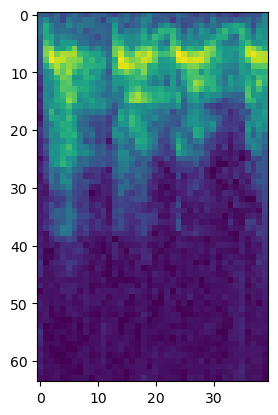

In [41]:
spectogram = np.load(train_files[12])
plt.figure()
plt.imshow(spectogram)

In [42]:
label_mapping

{0: 0,
 10: 1,
 11: 2,
 12: 3,
 13: 4,
 14: 5,
 15: 6,
 16: 7,
 17: 8,
 18: 9,
 19: 10,
 1: 11,
 20: 12,
 21: 13,
 22: 14,
 23: 15,
 24: 16,
 25: 17,
 26: 18,
 27: 19,
 28: 20,
 29: 21,
 2: 22,
 30: 23,
 31: 24,
 32: 25,
 33: 26,
 34: 27,
 35: 28,
 36: 29,
 37: 30,
 38: 31,
 39: 32,
 3: 33,
 40: 34,
 41: 35,
 42: 36,
 43: 37,
 44: 38,
 45: 39,
 46: 40,
 47: 41,
 48: 42,
 49: 43,
 4: 44,
 5: 45,
 6: 46,
 7: 47,
 8: 48,
 9: 49}

In [43]:
input_shape=get_spectrogram_shape(train_files[7],num_classes,label_mapping)
input_shape

for i in range(500):
    input_shape_cur=get_spectrogram_shape(test_files[i],num_classes,label_mapping)
    if(input_shape_cur != input_shape):
        print("not equal")


In [44]:
num_classes

50

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, ReLU,MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

checkpoint_path = "vgg16_1.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.005)
lr_scheduler = LearningRateScheduler(scheduler)

model = Sequential()
model.add(Conv2D(input_shape=input_shape, filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation="relu", kernel_regularizer=l2(0.01)))

model.add(Dense(units=num_classes, activation="softmax"))

epochs, lrate = 150, 0.0001
decay = lrate/epochs

opt = Adam(learning_rate=lrate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


y_train = extract_labels(train_dataset)  
class_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = dict(enumerate(class_weights))
print(class_weights)

history = model.fit(train_dataset, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=val_dataset,
                    batch_size=64,
                    callbacks=[early, checkpoint, lr_scheduler],
                    class_weight=class_weights)

{0: 1.8837209302325582, 1: 0.675, 2: 0.7043478260869566, 3: 0.7864077669902912, 4: 0.6864406779661016, 5: 0.84375, 6: 1.975609756097561, 7: 0.680672268907563, 8: 0.9878048780487805, 9: 0.81, 10: 0.9642857142857143, 11: 2.25, 12: 1.125, 13: 3.375, 14: 0.7641509433962265, 15: 1.208955223880597, 16: 2.7, 17: 1.0, 18: 1.265625, 19: 0.7714285714285715, 20: 1.653061224489796, 21: 1.7608695652173914, 22: 0.9642857142857143, 23: 1.8837209302325582, 24: 1.396551724137931, 25: 0.9101123595505618, 26: 1.125, 27: 3.375, 28: 0.7168141592920354, 29: 0.6982758620689655, 30: 1.0657894736842106, 31: 1.5576923076923077, 32: 2.892857142857143, 33: 1.1408450704225352, 34: 0.7168141592920354, 35: 0.7105263157894737, 36: 0.7431192660550459, 37: 1.1911764705882353, 38: 0.7168141592920354, 39: 0.680672268907563, 40: 0.7168141592920354, 41: 0.6923076923076923, 42: 1.5576923076923077, 43: 0.81, 44: 0.9529411764705882, 45: 1.3278688524590163, 46: 1.0253164556962024, 47: 0.8709677419354839, 48: 0.8617021276595744

KeyboardInterrupt: 

In [104]:
from keras.models import Model

base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                  input_shape = input_shape,
                  weights = None)
base_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
x = Flatten()(base_model.output)

# Add Dense layers
# Add any additional Dense layers if required
x = Dense(1024, activation='relu')(x)  # Example additional layer
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_dataset, 
          epochs=100, 
          verbose=1,
          validation_data=val_dataset,
          validation_steps=10,
          class_weight=class_weights,
          callbacks=[early, checkpoint])

Epoch 1/100
    480/Unknown - 34s 55ms/step - loss: 3.3763 - accuracy: 0.1250
Epoch 1: val_accuracy did not improve from 0.51958
480/480 [==============================] - 38s 63ms/step - loss: 3.3763 - accuracy: 0.1250 - val_loss: 3.3819 - val_accuracy: 0.1562
Epoch 2/100
479/480 [============================>.] - ETA: 0s - loss: 2.2233 - accuracy: 0.3702
Epoch 2: val_accuracy did not improve from 0.51958
480/480 [==============================] - 35s 59ms/step - loss: 2.2226 - accuracy: 0.3703 - val_loss: 3.1442 - val_accuracy: 0.2062
Epoch 3/100
480/480 [==============================] - ETA: 0s - loss: 1.6408 - accuracy: 0.5124
Epoch 3: val_accuracy did not improve from 0.51958
480/480 [==============================] - 35s 57ms/step - loss: 1.6408 - accuracy: 0.5124 - val_loss: 2.9349 - val_accuracy: 0.2562
Epoch 4/100
480/480 [==============================] - ETA: 0s - loss: 1.1829 - accuracy: 0.6406
Epoch 4: val_accuracy did not improve from 0.51958
480/480 [===================

KeyboardInterrupt: 

In [50]:
history_dict = history.history

# Loss Values
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Accuracy Values
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

# Number of epochs
epochs = range(1, len(loss_values) + 1)

# Plotting Loss Graph
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

{0: 2.3969072164948453,
 1: 0.5284090909090909,
 2: 2.1136363636363638,
 3: 0.8215547703180212}

In [69]:
model.load_weights(checkpoint_path)

test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

42/42 [==============================] - 1s 3ms/step - loss: 1.5282 - accuracy: 0.5939
Test Loss: 1.5282026529312134
Test Accuracy: 0.5938668847084045


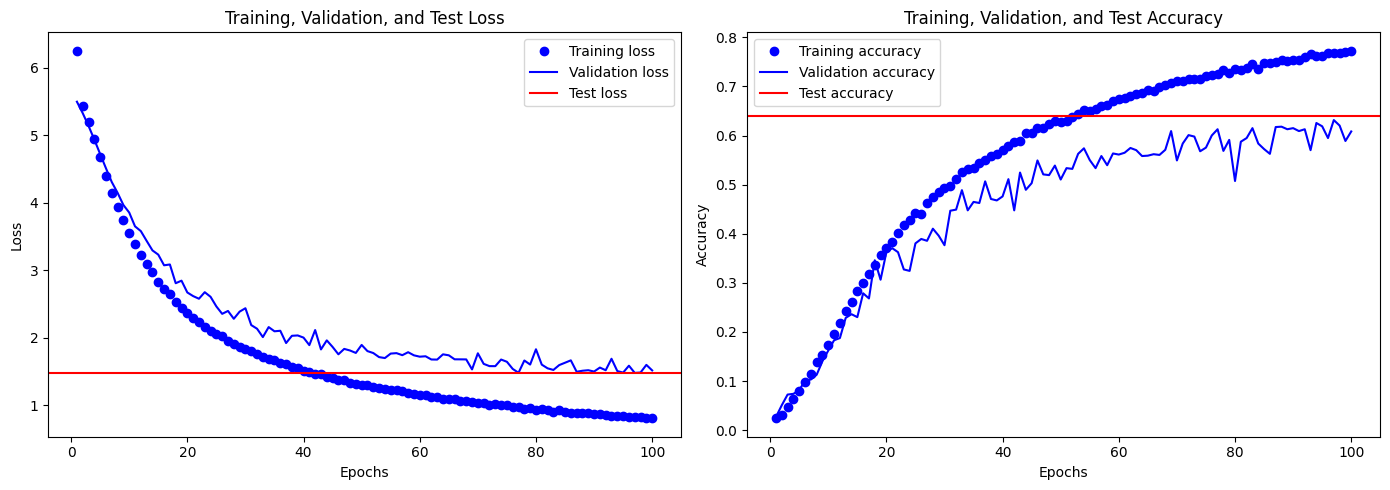

In [67]:
history_dict = history.history

# Training and Validation Loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Training and Validation Accuracy
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)

# Plotting
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.axhline(y=test_loss, color='r', linestyle='-', label='Test loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='-', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [471]:
y_pred = model.predict(test_dataset)


117/117 [==============================] - 3s 6ms/step


In [54]:
y_true = []
y_pred = []

for features, labels in test_dataset:
    # Generate predictions
    predictions = model.predict(features)

    # Convert one-hot encoded labels to class labels
    labels = np.argmax(labels, axis=1)

    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Store true and predicted labels
    y_true.append(labels)
    y_pred.append(predicted_labels)

# Concatenate results from all batches
y_true = np.concatenate(y_true)

y_pred = np.concatenate(y_pred)

1/1 [==============================] - 0s 85ms/step


In [55]:
class_labels = ""
for spectrogram, one_hot_labels in test_dataset.take(1):
    # 'spectrogram' contains a batch of spectrograms
    # 'one_hot_labels' contains the corresponding batch of one-hot encoded labels

    # To decode these one-hot labels into class labels:
    class_labels = np.argmax(one_hot_labels.numpy(), axis=1)

    # Now 'class_labels' contains the class labels for this batch
    # You can process these labels as needed
    break
class_labels

array([41, 33, 36, 13, 11, 28, 46, 25,  5, 19, 33, 35, 32, 45,  0, 21, 28,
       42, 13, 19, 45, 35, 30, 14, 16, 20,  1,  7, 22, 30,  3, 16],
      dtype=int64)

In [56]:
label_mapping.items()

dict_items([(0, 0), (10, 1), (11, 2), (12, 3), (13, 4), (14, 5), (15, 6), (16, 7), (17, 8), (18, 9), (19, 10), (1, 11), (20, 12), (21, 13), (22, 14), (23, 15), (24, 16), (25, 17), (26, 18), (27, 19), (28, 20), (29, 21), (2, 22), (30, 23), (31, 24), (32, 25), (33, 26), (34, 27), (35, 28), (36, 29), (37, 30), (38, 31), (39, 32), (3, 33), (40, 34), (41, 35), (42, 36), (43, 37), (44, 38), (45, 39), (46, 40), (47, 41), (48, 42), (49, 43), (4, 44), (5, 45), (6, 46), (7, 47), (8, 48), (9, 49)])

In [57]:
vocabulary = pd.read_csv("vocabulary.csv")
label_one_hot_class_test = {}
for label, values in label_mapping.items():
    label_one_hot_class_test[values]=label_one_hot_class[label]

In [58]:
label_one_hot_class

{0: 'dog',
 14: 'chirping_birds',
 36: 'vacuum_cleaner',
 19: 'thunderstorm',
 30: 'door_wood_knock',
 34: 'can_opening',
 9: 'crow',
 22: 'clapping',
 48: 'fireworks',
 41: 'chainsaw',
 47: 'airplane',
 31: 'mouse_click',
 17: 'pouring_water',
 45: 'train',
 8: 'sheep',
 15: 'water_drops',
 46: 'church_bells',
 37: 'clock_alarm',
 32: 'keyboard_typing',
 16: 'wind',
 25: 'footsteps',
 4: 'frog',
 3: 'cow',
 27: 'brushing_teeth',
 43: 'car_horn',
 12: 'crackling_fire',
 40: 'helicopter',
 29: 'drinking_sipping',
 10: 'rain',
 7: 'insects',
 26: 'laughing',
 6: 'hen',
 44: 'engine',
 23: 'breathing',
 20: 'crying_baby',
 49: 'hand_saw',
 24: 'coughing',
 39: 'glass_breaking',
 28: 'snoring',
 18: 'toilet_flush',
 2: 'pig',
 35: 'washing_machine',
 38: 'clock_tick',
 21: 'sneezing',
 1: 'rooster',
 11: 'sea_waves',
 42: 'siren',
 5: 'cat',
 33: 'door_wood_creaks',
 13: 'crickets'}

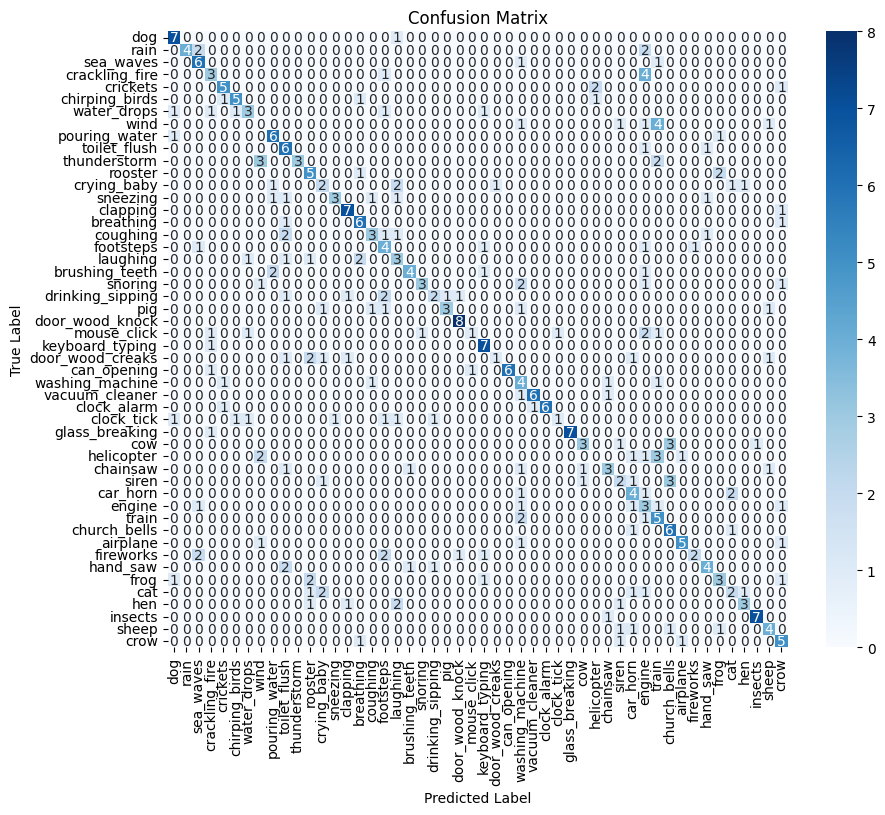

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_true_labels = [label_one_hot_class_test[idx] for idx in y_true]
y_pred_labels = [label_one_hot_class_test[idx] for idx in y_pred]
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(label_one_hot_class_test.values()))

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_one_hot_class_test.values(), yticklabels=label_one_hot_class_test.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [54]:
y_true, y_pred

(array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([ 9,  2, 11, ...,  1,  2,  5], dtype=int64))

In [23]:
total_samples = sum(1 for _ in train_dataset)
print("Total training samples:", total_samples * 32)


C:\Users\there\AppData\Local\Temp\ipykernel_7164\124385931.py:7: RuntimeWarning: invalid value encountered in log
  spectrogram = np.log(spectrogram + epsilon)


Total training samples: 15264


In [3]:
model = tf.keras.models.load_model('moodels/23_test.keras')


In [6]:
print(K.eval(model.optimizer.lr))


0.0005


In [24]:
n_mels

64

In [143]:
sample_sound = filtered_df.iloc[0]

spectrogram = np.load("data/val/105_315935_1.npy")
spectrogram = np.expand_dims(spectrogram, axis=-1)

original_label = int(os.path.basename("data/val/105_315935_1.npy").split('_')[0])
mapped_label = map_labels(original_label, label_mapping)
if np.isinf(spectrogram).any() or np.isnan(spectrogram).any():
    raise ValueError("Spectrogram contains inf or NaN values after normalization")

label_one_hot = tf.keras.utils.to_categorical(mapped_label, num_classes=num_classes)
print(label_one_hot,original_label,mapped_label,label_mapping)
print(spectogram)
audio_signal = librosa.core.spectrum.griffinlim(spectogram)
ipd.Audio(data=audio_signal ,rate=sr)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] 105 0 {105: 0, 106: 1, 110: 2, 144: 3, 146: 4, 153: 5, 157: 6, 160: 7, 168: 8, 170: 9, 185: 10, 190: 11, 198: 12, 20: 13, 24: 14, 35: 15, 38: 16, 3: 17, 40: 18, 55: 19, 57: 20, 5: 21, 60: 22, 69: 23, 6: 24, 72: 25, 74: 26, 77: 27, 78: 28, 91: 29}
[[-1.3161515e-01 -1.0664776e-01 -1.1584794e-01 ... -1.4527607e-01
  -1.7575634e-01 -1.9957384e-01]
 [ 1.1682151e-02  7.9249017e-02  7.5324528e-02 ...  4.6326704e-03
   8.3144251e-03 -5.5749580e-02]
 [ 7.1364790e-02  7.7602722e-02  6.4140901e-02 ... -3.7986226e-03
   3.6727401e-04 -2.3390146e-02]
 ...
 [-9.9844044e-01 -9.9442965e-01 -7.7511650e-01 ... -7.5590873e-01
  -7.5932145e-01 -8.9220583e-01]
 [-1.0000000e+00 -1.0000000e+00 -8.9737111e-01 ... -8.8612032e-01
  -8.7972915e-01 -9.8143196e-01]
 [-9.9915099e-01 -9.9972677e-01 -1.0000000e+00 ... -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00]]
